<a href="https://colab.research.google.com/github/salman1097/CSCN8010/blob/main/YOLO_NAS%2BSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Object Detection & Image Segmentation using YOLO-NAS + SAM

### Install required packages

In [14]:
!pip install ultralytics install super-gradients -q
!pip install -U git+https://github.com/Deci-AI/super-gradients
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
  Cloning https://github.com/Deci-AI/super-gradients to /tmp/pip-req-build-i0myku86
  Running command git clone --filter=blob:none --quiet https://github.com/Deci-AI/super-gradients /tmp/pip-req-build-i0myku86
  Resolved https://github.com/Deci-AI/super-gradients to commit e0ccacf8868ffa1296fa4f8407c03d2bc227312c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached boto3-1.39.9-py3-none-any.whl.metadata (6.7 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached torchmetrics-0.8.0-py3-none-any.whl.metadata (20 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached onnxruntime-1.22.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.6 kB)
  Using cached onnx-1.15.

--2025-07-21 01:59:10--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.31, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.3’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   161MB/s    in 14s     

2025-07-21 01:59:24 (178 MB/s) - ‘sam_vit_h_4b8939.pth.3’ saved [2564550879/2564550879]



In [15]:

# now your original imports
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from super_gradients.training import models


[2025-07-21 01:59:38] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


DEBUG:2025-07-21 01:59:51,179:jax._src.path:31: etils.epath found. Using etils.epath for file I/O.
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
[2025-07-21 01:59:55] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


### Import required libraries

### Detections with YOLO-NAS

In [20]:
image_path = '/content/my_test.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

model = models.get('yolo_nas_l', pretrained_weights="coco")
model.predict(image, conf=0.25).show()

conf_threshold = 0.25
detection_pred = model.predict(image_path, conf=conf_threshold)
detections = detection_pred.save('output_folder')

[2025-07-21 02:08:44] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2025-07-21 02:08:44] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


IndexError: list index out of range

In [ ]:
# Extract bounding boxes, confidence scores, and labels
detection_pred = model.predict(image_path, conf=conf_threshold)._images_prediction_lst

bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
confidence = detection_pred[0].prediction.confidence.tolist()
labels = detection_pred[0].prediction.labels.tolist()

[2023-09-24 05:05:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


### Add helper functions for SAM

In [ ]:
# Helper functions - https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

def show_mask(mask, ax, random_color=False):
    if random_color:
      color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
      color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=365):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', maker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
# SAM Model for masking
sam_checkpoint = 'sam_vit_h_4b8939.pth'
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### Segmentation With SAM

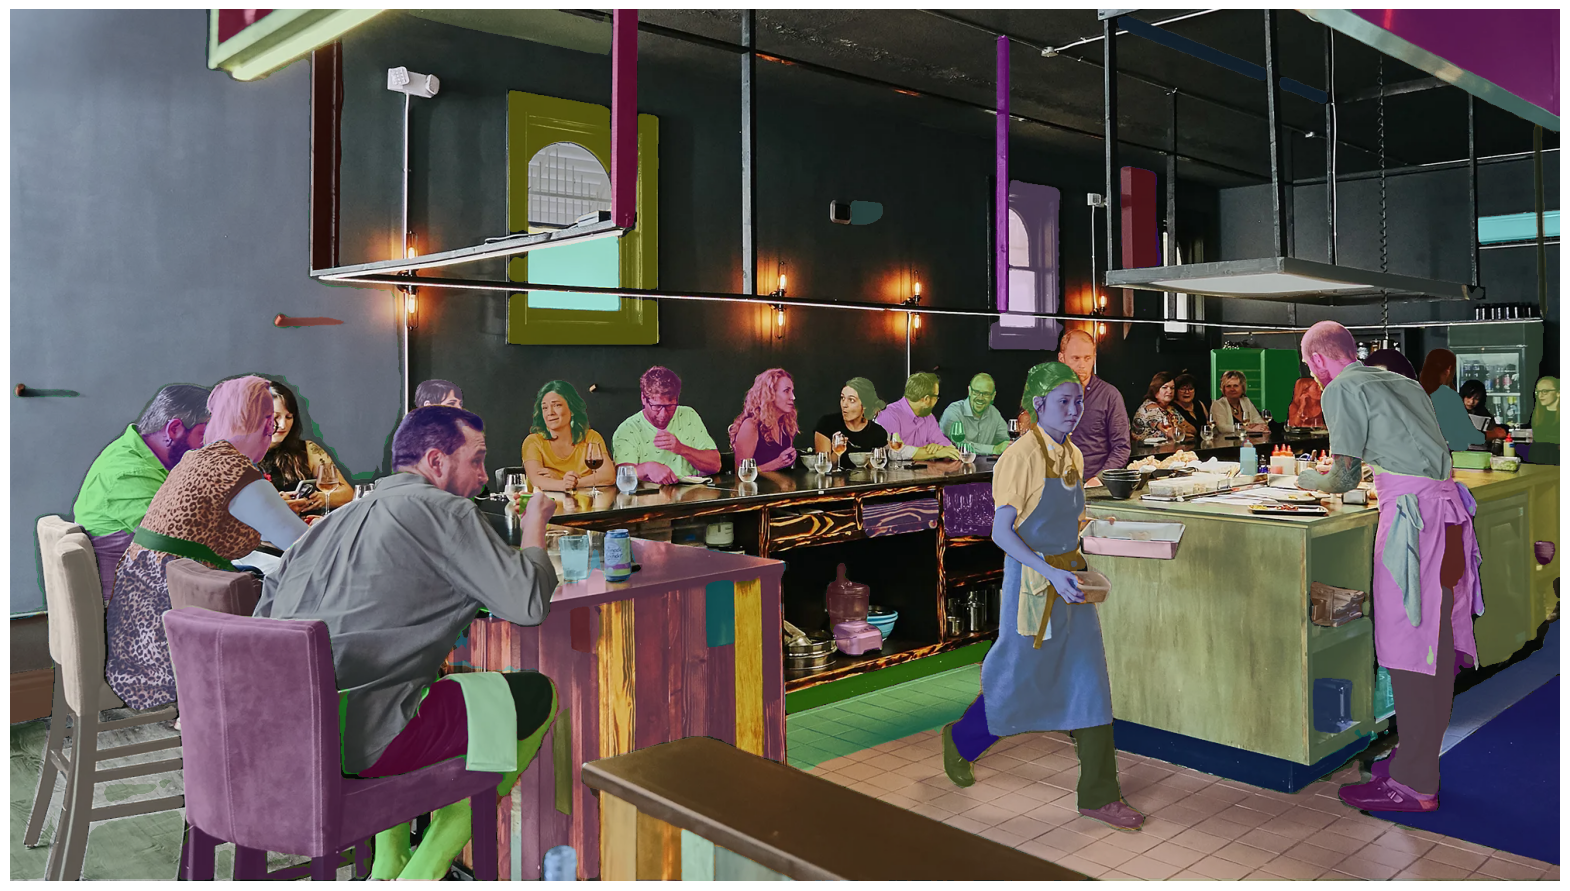

In [ ]:
# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(sam)
mask = mask_generator.generate(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(mask)
plt.axis('off')
plt.show()

In [ ]:
# Load Class Names from COCO dataset
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
          "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
          "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
          "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
          "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
          "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
          "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
          "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
          "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
          "teddy bear", "hair drier", "toothbrush"
        ]

In [ ]:
# Create a predictor for SAM
image = cv2.imread(image_path)
predictor = SamPredictor(sam)
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

### Display prediction

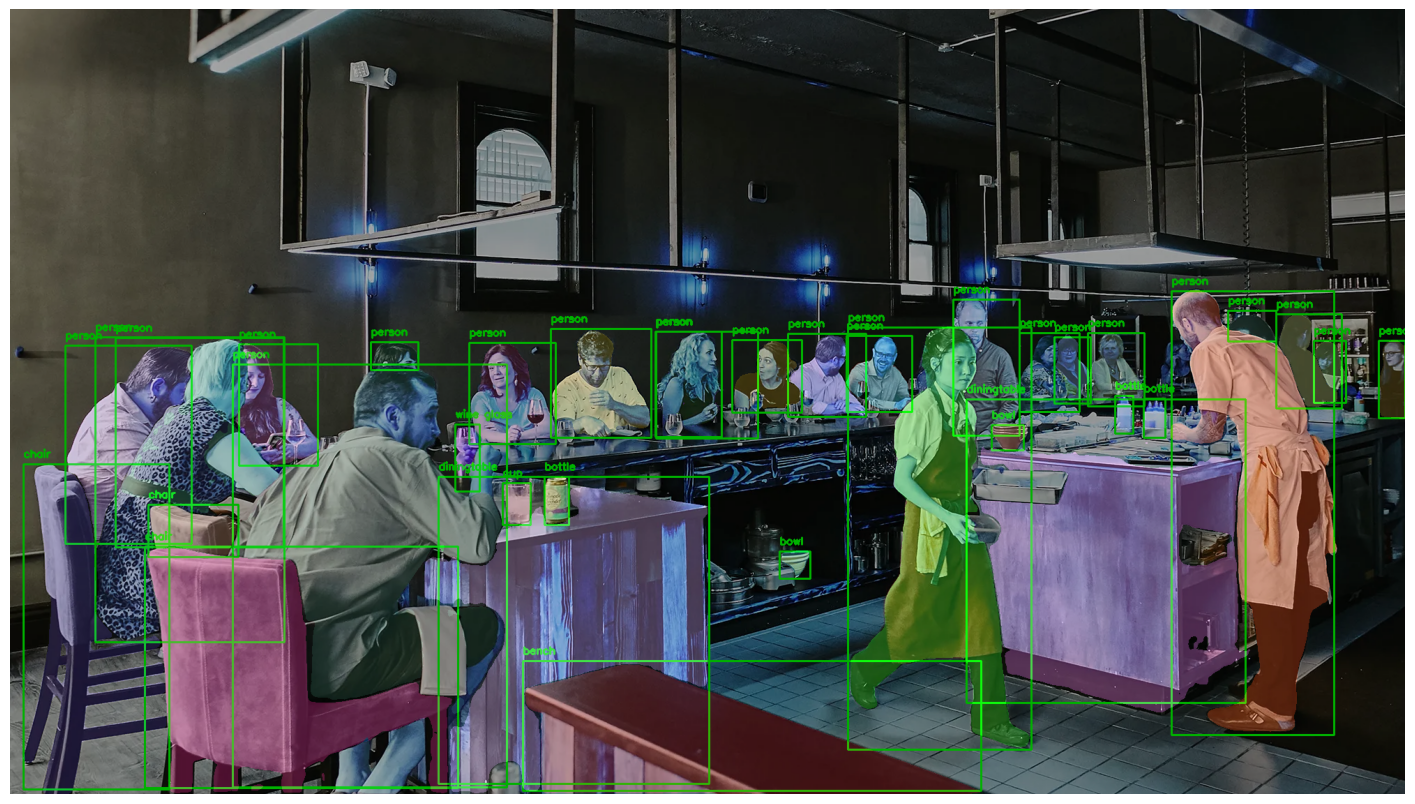

In [ ]:
# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes_xyxy[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)

# Display the image
plt.figure(figsize=(18, 18))
plt.imshow(final_image)
plt.axis('off')
plt.savefig('output_folder/prediction.jpg')  # Save the combined output
plt.show()


In [3]:
!pip install ultralytics super-gradients -q
!pip install git+https://github.com/facebookresearch/segment-anything.git -q
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 93.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   